# K Fold Evalutation Jupyter Notebook


In [1]:
import numpy as np
import os
import pandas as pd
import torch
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
import torchvision.transforms as v2
from efficientnet_pytorch import EfficientNet  # Ensure you have this package installed
from sklearn import model_selection, metrics

import torch
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from PIL import Image
import re
from PIL import ImageFile

/home/iambrink/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define transformations for training and testing
train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(320, antialias=True),
    v2.RandomCrop(320),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(320, antialias=True),
    v2.CenterCrop(size=320),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
# Create the dataset class
class NOHThyroidDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, base_path, transform=None):
        self.dataframe = dataframe
        self.base_path = base_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = os.path.join(self.base_path, self.dataframe['image_path'][idx].replace("\\", "/"))
        label = self.dataframe['Surgery diagnosis in number'][idx]
        
        try:
            image = Image.open(image_path)
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Handle the case where the image can't be loaded
            # You could return a placeholder image or raise an error
            # For now, we'll return a blank tensor and a placeholder label
            image = torch.zeros((3, 320, 320))  # Assuming the image shape is (C, H, W)
            label = -1  # Placeholder label for errors
            
        return image, label


In [17]:
img_ds = pd.read_csv('/home/iambrink/NOH_Thyroid_Cancer_Data/NOV_Kfold_Data.csv')

base_path = "/home/iambrink/NOH_Thyroid_Cancer_Data/"

batch_size = 16

epochs = 10

In [16]:
# Prepare for K-Fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
accuracies = []
f1_scores = []
precisions = []
recalls = []
best_auc = 0
best_val_accuracy = 0


In [19]:
# Display the GPU's
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")
    # List information about each GPU
    for i in range(num_gpus):
        gpu_info = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {gpu_info.name}")
        print(f"   Compute Capability: {gpu_info.major}.{gpu_info.minor}")
        print(f"   Total Memory: {gpu_info.total_memory / (1024 ** 3):.2f} GB\n")
else:
    print("No GPUs available.")

Number of available GPUs: 1
GPU 0: NVIDIA GeForce RTX 4070
   Compute Capability: 8.9
   Total Memory: 11.99 GB



In [23]:
from tqdm import tqdm  # Import tqdm

for fold, (train_index, val_index) in enumerate(kf.split(img_ds, img_ds['Surgery diagnosis in number'])):
    print(f"\nFold_{fold}")

    # Splitting the dataset
    train_df = img_ds.iloc[train_index].reset_index(drop=True)
    val_df = img_ds.iloc[val_index].reset_index(drop=True)

    # Create datasets for this fold
    train_dataset = NOHThyroidDataset(dataframe=train_df, base_path=base_path, transform=train_transform)
    val_dataset = NOHThyroidDataset(dataframe=val_df, base_path=base_path, transform=test_transform)

    # Create DataLoaders
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    Scheduler = torch.nn.BCEWithLogitsLoss()
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device
    model.to(device)
    # Training loop
    # Training loop
    model.train()
    for epoch in range(epochs):  # Adjust epoch number based on your needs
        print(f"\nEpoch {epoch + 1}/{epochs}")  # Print the current epoch
        for images, labels in tqdm(trainloader, desc="Training", unit="batch"):
            # Move data and labels to the device (GPU)
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)

            # Change labels shape to [batch_size, 1]
            labels = labels.unsqueeze(1)  # Add an extra dimension to labels

            loss = Scheduler(outputs, labels.float())
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    y_true = []
    y_pred_proba = []

    with torch.no_grad():
        for images, labels in tqdm(valloader, desc="Evaluating", unit="batch"):
            # Move data and labels to the device (GPU)
            images, labels = images.to(device), labels.to(device)

            # Filter out images with placeholder labels
            valid_indices = labels != -1  # Get valid indices where labels are not -1
            if valid_indices.sum() == 0:
                continue  # Skip this batch if all labels are invalid
            
            valid_images = images[valid_indices]
            valid_labels = labels[valid_indices]
            
            outputs = model(valid_images)
            y_true.extend(valid_labels.cpu().numpy())
            y_pred_proba.extend(outputs.cpu().numpy())

    # Convert the tensors back to CPU before calculating metrics
    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)

    # Binary classification, convert probabilities to binary predictions
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Calculate metrics
    auc = roc_auc_score(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    # Store the metrics
    auc_scores.append(auc)
    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    # Print fold metrics
    print(f"\n\tAUC for this fold: {auc:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    # Save the best model based on AUC
    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), f"Best_model_trial_5_with_AUC_{auc:.4f}.pth")  # Save the model for this fold



Fold_0
Loaded pretrained weights for efficientnet-b0

Epoch 1/10


Training: 100%|██████████| 101/101 [01:40<00:00,  1.01batch/s]



Epoch 2/10


Training: 100%|██████████| 101/101 [01:23<00:00,  1.21batch/s]



Epoch 3/10


Training: 100%|██████████| 101/101 [01:22<00:00,  1.23batch/s]



Epoch 4/10


Training: 100%|██████████| 101/101 [01:20<00:00,  1.26batch/s]



Epoch 5/10


Training: 100%|██████████| 101/101 [01:20<00:00,  1.26batch/s]



Epoch 6/10


Training: 100%|██████████| 101/101 [01:19<00:00,  1.27batch/s]



Epoch 7/10


Training: 100%|██████████| 101/101 [01:20<00:00,  1.26batch/s]



Epoch 8/10


Training: 100%|██████████| 101/101 [01:20<00:00,  1.26batch/s]



Epoch 9/10


Training: 100%|██████████| 101/101 [01:19<00:00,  1.26batch/s]



Epoch 10/10


Evaluating: 100%|██████████| 26/26 [00:22<00:00,  1.13batch/s]



	AUC for this fold: 0.9597, Accuracy: 0.9381, F1: 0.9611, Precision: 0.9364, Recall: 0.9872

Fold_1
Loaded pretrained weights for efficientnet-b0

Epoch 1/10


Training: 100%|██████████| 101/101 [01:22<00:00,  1.22batch/s]



Epoch 2/10


Training: 100%|██████████| 101/101 [01:20<00:00,  1.25batch/s]



Epoch 3/10


Training: 100%|██████████| 101/101 [01:18<00:00,  1.29batch/s]



Epoch 4/10


Training: 100%|██████████| 101/101 [01:18<00:00,  1.29batch/s]



Epoch 5/10


Training: 100%|██████████| 101/101 [01:18<00:00,  1.29batch/s]



Epoch 6/10


Training: 100%|██████████| 101/101 [01:18<00:00,  1.29batch/s]



Epoch 7/10


Training: 100%|██████████| 101/101 [01:18<00:00,  1.28batch/s]



Epoch 8/10


Training: 100%|██████████| 101/101 [01:18<00:00,  1.29batch/s]



Epoch 9/10


Training: 100%|██████████| 101/101 [01:18<00:00,  1.29batch/s]



Epoch 10/10


Evaluating: 100%|██████████| 26/26 [00:21<00:00,  1.21batch/s]



	AUC for this fold: 0.9692, Accuracy: 0.9158, F1: 0.9450, Precision: 0.9574, Recall: 0.9329

Fold_2
Loaded pretrained weights for efficientnet-b0

Epoch 1/10


Training: 100%|██████████| 101/101 [01:22<00:00,  1.22batch/s]



Epoch 2/10


Training: 100%|██████████| 101/101 [01:18<00:00,  1.29batch/s]



Epoch 3/10


Training: 100%|██████████| 101/101 [01:18<00:00,  1.28batch/s]



Epoch 4/10


Training: 100%|██████████| 101/101 [01:17<00:00,  1.30batch/s]



Epoch 5/10


Training: 100%|██████████| 101/101 [01:18<00:00,  1.29batch/s]



Epoch 6/10


Training: 100%|██████████| 101/101 [01:18<00:00,  1.29batch/s]



Epoch 7/10


Training: 100%|██████████| 101/101 [01:18<00:00,  1.28batch/s]



Epoch 8/10


Training: 100%|██████████| 101/101 [01:18<00:00,  1.29batch/s]



Epoch 9/10


Training: 100%|██████████| 101/101 [01:17<00:00,  1.30batch/s]



Epoch 10/10


Evaluating: 100%|██████████| 26/26 [00:21<00:00,  1.20batch/s]



	AUC for this fold: 0.9620, Accuracy: 0.9380, F1: 0.9606, Precision: 0.9472, Recall: 0.9744

Fold_3
Loaded pretrained weights for efficientnet-b0

Epoch 1/10


Training: 100%|██████████| 101/101 [01:21<00:00,  1.24batch/s]



Epoch 2/10


Training: 100%|██████████| 101/101 [01:21<00:00,  1.25batch/s]



Epoch 3/10


Training: 100%|██████████| 101/101 [01:20<00:00,  1.25batch/s]



Epoch 4/10


Training: 100%|██████████| 101/101 [01:20<00:00,  1.25batch/s]



Epoch 5/10


Training: 100%|██████████| 101/101 [01:19<00:00,  1.26batch/s]



Epoch 6/10


Training: 100%|██████████| 101/101 [01:20<00:00,  1.26batch/s]



Epoch 7/10


Training: 100%|██████████| 101/101 [01:21<00:00,  1.24batch/s]



Epoch 8/10


Training: 100%|██████████| 101/101 [01:20<00:00,  1.25batch/s]



Epoch 9/10


Training: 100%|██████████| 101/101 [01:20<00:00,  1.26batch/s]



Epoch 10/10


Evaluating: 100%|██████████| 26/26 [00:21<00:00,  1.21batch/s]



	AUC for this fold: 0.9640, Accuracy: 0.9156, F1: 0.9448, Precision: 0.9604, Recall: 0.9297

Fold_4
Loaded pretrained weights for efficientnet-b0

Epoch 1/10


Training: 100%|██████████| 101/101 [01:22<00:00,  1.22batch/s]



Epoch 2/10


Training: 100%|██████████| 101/101 [01:22<00:00,  1.23batch/s]



Epoch 3/10


Training: 100%|██████████| 101/101 [01:21<00:00,  1.23batch/s]



Epoch 4/10


Training: 100%|██████████| 101/101 [01:21<00:00,  1.24batch/s]



Epoch 5/10


Training: 100%|██████████| 101/101 [01:20<00:00,  1.25batch/s]



Epoch 6/10


Training: 100%|██████████| 101/101 [01:20<00:00,  1.25batch/s]



Epoch 7/10


Training: 100%|██████████| 101/101 [01:20<00:00,  1.25batch/s]



Epoch 8/10


Training: 100%|██████████| 101/101 [01:20<00:00,  1.25batch/s]



Epoch 9/10


Training: 100%|██████████| 101/101 [01:20<00:00,  1.25batch/s]



Epoch 10/10


Evaluating: 100%|██████████| 26/26 [00:21<00:00,  1.21batch/s]



	AUC for this fold: 0.9740, Accuracy: 0.9206, F1: 0.9479, Precision: 0.9668, Recall: 0.9297


In [24]:
def print_max_and_index(metric_list, metric_name):
    max_value = max(metric_list)
    max_index = metric_list.index(max_value)
    print(f'Max {metric_name}: {max_value:.4f} at index {max_index}')

# Printing max values and indices for each metric
print_max_and_index(auc_scores, 'AUC Score')
print_max_and_index(accuracies, 'Accuracy')
print_max_and_index(f1_scores, 'F1 Score')
print_max_and_index(precisions, 'Precision')
print_max_and_index(recalls, 'Recall')

Max AUC Score: 0.9740 at index 4
Max Accuracy: 0.9381 at index 0
Max F1 Score: 0.9611 at index 0
Max Precision: 0.9668 at index 4
Max Recall: 0.9872 at index 0


In [25]:
# Calculate mean metrics across all folds
mean_auc = np.mean(auc_scores)
mean_accuracy = np.mean(accuracies)
mean_f1 = np.mean(f1_scores)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

print(f"\nMean AUC across folds: {mean_auc:.4f}")
print(f"Mean Accuracy across folds: {mean_accuracy:.4f}")
print(f"Mean F1 across folds: {mean_f1:.4f}")
print(f"Mean Precision across folds: {mean_precision:.4f}")
print(f"Mean Recall across folds: {mean_recall:.4f}")


Mean AUC across folds: 0.9658
Mean Accuracy across folds: 0.9256
Mean F1 across folds: 0.9519
Mean Precision across folds: 0.9536
Mean Recall across folds: 0.9508


In [ ]:
# Reinitialize your model
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1)

# Load the state dict into the model
model.load_state_dict(torch.load(f"/home/iambrink/NOH_Thyroid_Cancer_Data/Best_model_trial_5_with_AUC_0.9740.pth"))

# Set the model to evaluation mode
model.eval()

Evaluating: 100%|██████████| 30/30 [00:32<00:00,  1.10s/batch]

Threshold (0.2) - AUC: 0.9975, Accuracy: 0.9832, F1: 0.9888, Precision: 0.9944, Recall: 0.9832

Confusion Matrix:
[[115   2]
 [  6 352]]


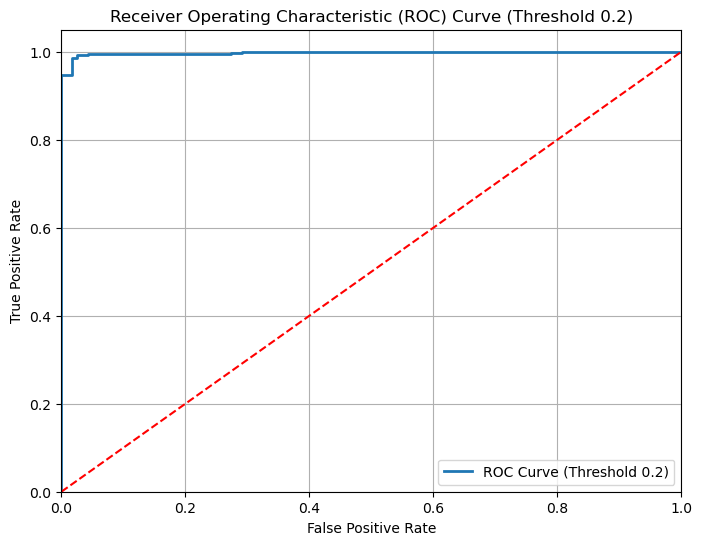

Threshold (0.5) - AUC: 0.9975, Accuracy: 0.9789, F1: 0.9859, Precision: 0.9943, Recall: 0.9777

Confusion Matrix:
[[115   2]
 [  8 350]]


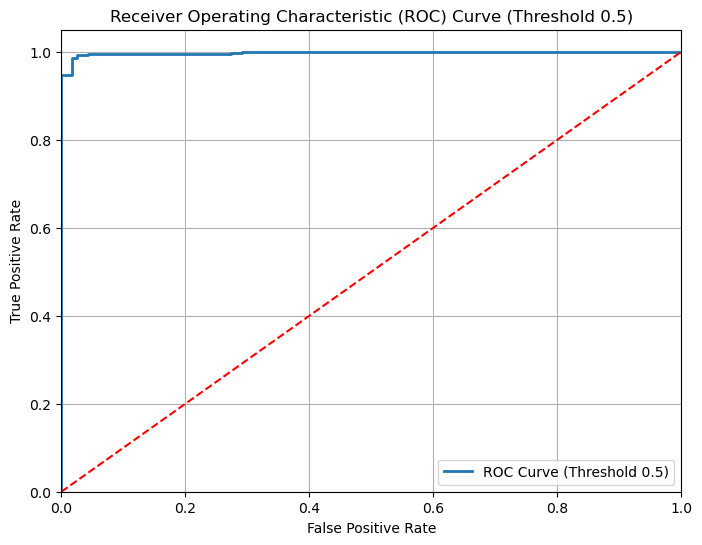

Threshold (0.8) - AUC: 0.9975, Accuracy: 0.9747, F1: 0.9831, Precision: 0.9943, Recall: 0.9721

Confusion Matrix:
[[115   2]
 [ 10 348]]


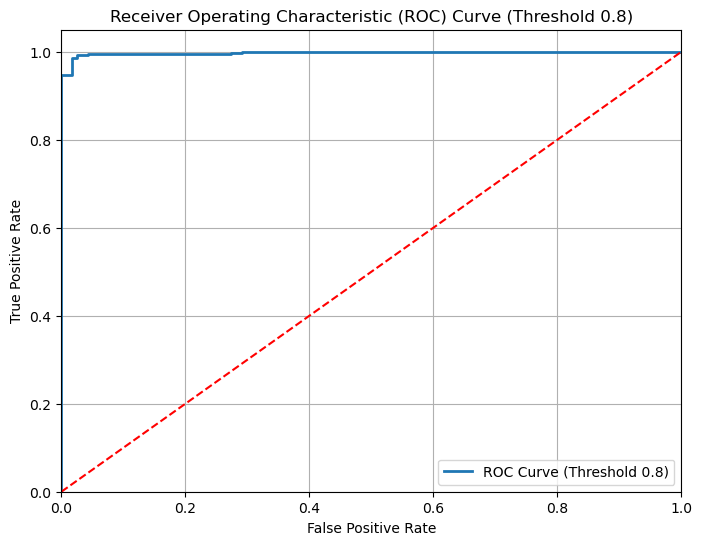

In [29]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load your CSV file
data_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/NOV_Kfold_Data.csv'  # Adjust the path to your CSV file
dataframe = pd.read_csv(data_path)

# Step 1: Filter the test data
test_df = dataframe[dataframe['test_split'] == 'test'].reset_index(drop=True)

# Step 2: Create a test dataset and dataloader
test_dataset = NOHThyroidDataset(dataframe=test_df, base_path=base_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 3: Evaluate the model
model.eval()  # Ensure the model is in evaluation mode
y_true = []
y_pred_proba = []

with torch.no_grad():  # Disable gradient calculation
    for images, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
        # Filter out images with placeholder labels (if any)
        valid_indices = labels != -1  # Adjust based on your placeholder label handling
        if valid_indices.sum() == 0:
            continue  # Skip this batch if all labels are invalid

        valid_images = images[valid_indices]
        valid_labels = labels[valid_indices]

        outputs = model(valid_images)

        # Collect true labels and predicted probabilities
        y_true.extend(valid_labels.cpu().numpy())
        y_pred_proba.extend(outputs.cpu().numpy())

# Convert y_true and y_pred_proba to NumPy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)

# List of thresholds to evaluate
thresholds = [0.2, 0.5, 0.8]  # Adjust this list based on your needs

for threshold in thresholds:
    # Make predictions based on the current threshold
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate metrics for the current threshold
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)

    # Print out metrics
    print(f"Threshold ({threshold}) - AUC: {auc:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    # Confusion matrix for the current threshold
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (Threshold {threshold})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve (Threshold {threshold})')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
